# SA Figure 6: Multi-Field Climate Response to Volcanic Forcing

## Scientific Context
This notebook generates Figure 6, which analyzes the spatial patterns and temporal evolution of multiple climate fields following a 500 Tg equatorial volcanic eruption. The figure provides a comprehensive view of the coupled atmosphere-ocean-cryosphere response across three distinct time periods, revealing the mechanisms driving AMOC transitions.

## Experimental Design
- **Volcanic Simulation**: 500 Tg equatorial eruption at model year 7700
- **Ensemble**: 50-member Monte Carlo ensemble (volcanic minus control anomalies)
- **Model**: CESM1.3 iCESM with CAM5 atmosphere and POP2 ocean components
- **Time Periods Analyzed**:
  - Period 1: Years 7701-7705 (immediate post-eruption response, 0-5 years)
  - Period 2: Years 7706-7715 (transition phase, 5-15 years)
  - Period 3: Years 7716-7720 (recovery phase, 15-20 years)

## Figure Structure
**5 columns × 3 rows** showing temporal evolution of climate fields:

### Column A: Surface Air Temperature + Mean Sea Level Pressure
- Filled contours: Surface air temperature anomalies (TS, °C)
- Contours: Sea level pressure anomalies (PSL, KPa)
- Reveals atmospheric cooling and pressure pattern changes

### Column B: Sea Surface Salinity + Mixed Layer Depth
- Filled contours: Sea surface salinity anomalies (SSS, g/kg)
- Contours: Ocean mixed layer depth anomalies (HMXL, m)
- Shows haline forcing and upper ocean stratification changes

### Column C: Precipitation - Evaporation + Runoff + Sea Ice Fraction
- Filled contours: Net freshwater forcing (P-E+R, mm/day)
- Contours: Sea ice fraction anomalies (ICEFRAC, %)
- Captures freshwater budget and cryosphere response

### Column D: Barotropic Stream Function + Surface Wind Stress
- Filled contours: Barotropic stream function (BSF, Sv)
- Vectors: Surface wind stress (TAUX, TAUY, N/m²)
- Illustrates ocean circulation and wind-driven changes

### Column E: Atlantic Meridional Overturning Circulation (AMOC)
- Contours: AMOC strength (Sv) as function of depth and latitude
- Depth range: 0-5000 m
- Latitude range: 0-85°N
- Shows overturning circulation changes in Atlantic basin

## Data Processing Steps
1. **Load ensemble mean anomalies** for atmospheric and oceanic variables
2. **Regrid ocean variables** from POP2 tripole grid to regular lat-lon grid using xESMF
3. **Calculate derived fields**:
   - P-E+R from precipitation (PRECT), evaporation (QFLX), and runoff (ROFF_F)
   - Unit conversions (kg/m²/s to mm/day, m/s to mm/day)
4. **Temporal averaging** over three distinct periods
5. **Extract AMOC** from meridional overturning stream function
6. **Generate multi-panel figure** with geographic maps and depth-latitude sections

## Key Scientific Questions
- How do surface climate anomalies evolve across different time scales?
- What are the spatial patterns of freshwater forcing that affect ocean stratification?
- How do atmospheric pressure and wind stress changes drive ocean circulation response?
- What is the relationship between surface forcing and AMOC strength changes?
- How do sea ice anomalies contribute to salinity and buoyancy forcing?

## Variables Analyzed
- **TS**: Surface air temperature (K → °C)
- **PSL**: Mean sea level pressure (Pa → KPa)
- **SSS (SALT)**: Sea surface salinity (g/kg)
- **HMXL**: Ocean mixed layer depth (cm → m)
- **PRECT**: Precipitation rate (m/s → mm/day)
- **QFLX**: Surface evaporation flux (kg/m²/s → mm/day)
- **ROFF_F**: River runoff flux (kg/m²/s → mm/day)
- **ICEFRAC**: Sea ice fraction (fraction → %)
- **BSF**: Barotropic stream function (Sv)
- **TAUX, TAUY**: Zonal and meridional wind stress (N/m²)
- **MOC**: Meridional overturning circulation (Sv)

In [3]:
# Import libraries for multi-field climate analysis and visualization
# This cell imports all necessary packages for:
# - Data manipulation (numpy, xarray, pandas)
# - Statistical analysis (scipy)
# - Geographic plotting (cartopy)
# - Grid regridding (xesmf)
# - Color maps optimized for oceanography (cmocean)
# - Interactive widgets for exploratory analysis

# numpy/scipy stuff
import numpy as np
import numpy.ma as ma

from scipy.signal import argrelextrema
from scipy.stats import genextreme as gev

from netCDF4 import Dataset 

# matplotlib stuff
import matplotlib.pyplot as plt
#plt.style.use('seaborn-talk')
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib import colors
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyBboxPatch
import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.colors as mcolors

# data sci stuff
import xarray as xr
import pandas as pd

# system stuff
import os
import sys
import glob
import fnmatch

# netcdf stuff
from netCDF4 import Dataset
import datetime
import cftime
import nc_time_axis

# widgets stuff
import ipywidgets as widgets
from ipywidgets import interact,interactive

import xlrd
import cmocean as ocm

import xesmf as xe
from matplotlib import gridspec

import cartopy.crs as ccrs
import cmaps


import cmocean as ocm

In [4]:
# Initialize CF-compliant time decoder using cftime
# This ensures proper handling of non-standard calendar dates in climate model output
# Essential for CESM data which uses the "noleap" calendar (365 days/year, no leap years)

time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
time_coder

In [6]:
# Load freshwater budget components for P-E+R calculation
# Three components needed to compute net freshwater forcing:
# 1. PRECT: Total precipitation (atmospheric model output)
# 2. QFLX: Surface evaporation flux (atmospheric model output)
# 3. ROFF_F: River runoff flux (ocean model output, requires regridding)
# File naming: cesmi6gat31rblc230iveq-noeq500tg7701 indicates volcanic minus control ensemble mean anomalies
directory = '/scratch/pproc/eq500tg7701_ens/'
files = [
    'cesmi6gat31rblc230iveq-noeq500tg7701_atm_PRECT_ncea.nc',
    'cesmi6gat31rblc230iveq-noeq500tg7701_atm_QFLX_ncea.nc',
    'cesmi6gat31rblc230iveq-noeq500tg7701_ocn_ROFF_F_ncea.nc'
]

# Load the datasets into xarray

datasets = [xr.open_dataset(os.path.join(directory, file), decode_times=time_coder, decode_timedelta=True) for file in files]

for ds in datasets:
    print(ds)
# Print the datasets to verify

<xarray.Dataset> Size: 73MB
Dimensions:  (time: 3960, lat: 48, lon: 96, ilev: 27, lev: 26)
Coordinates:
  * time     (time) object 32kB 7676-02-01 00:00:00 ... 8006-01-01 00:00:00
  * lat      (lat) float64 384B -87.16 -83.48 -79.78 ... 79.78 83.48 87.16
  * lon      (lon) float64 768B 0.0 3.75 7.5 11.25 ... 345.0 348.8 352.5 356.2
  * ilev     (ilev) float64 216B 2.194 4.895 9.882 18.05 ... 956.0 985.1 1e+03
  * lev      (lev) float64 208B 3.545 7.389 13.97 23.94 ... 929.6 970.6 992.6
Data variables: (12/17)
    P0       float64 8B ...
    PRECT    (time, lat, lon) float32 73MB ...
    gw       (lat) float64 384B ...
    hyai     (ilev) float64 216B ...
    hyam     (lev) float64 208B ...
    hybi     (ilev) float64 216B ...
    ...       ...
    nlon     (lat) int32 192B ...
    nsbase   int32 4B ...
    ntrk     int32 4B ...
    ntrm     int32 4B ...
    ntrn     int32 4B ...
    wnummax  (lat) int32 192B ...
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    cas

In [7]:
# Inspect the latitude coordinates of runoff data (ROFF_F)

# Ocean model data uses POP2 displaced pole grid with 2D lat/lon coordinates (TLAT, TLONG)datasets[2].ROFF_F.TLAT
# This grid requires regridding to match the regular lat/lon grid of atmospheric variables

In [9]:
# Create regridder to transform ocean data from POP2 tripole grid to regular lat-lon grid
# Ocean variables (ROFF_F) are on the POP2 displaced pole grid (384×320, curvilinear)
# Atmospheric variables (PRECT, QFLX) are on regular lat-lon grid (288×192)
# Method: 'nearest_s2d' uses nearest neighbor on a 2D spherical surface
lon = datasets[0].PRECT.lon
lat = datasets[0].PRECT.lat
# regrider

grid_in = {'lon': datasets[2].ROFF_F.TLONG, 'lat': datasets[2].ROFF_F.TLAT}
grid_out = {'lon': lon, 'lat': lat}
regridder = xe.Regridder(grid_in, grid_out, 'nearest_s2d', reuse_weights=False)


In [45]:
# Calculate annual means of freshwater budget components
# Resample from monthly data to yearly averages using 'YE' (year-end) frequency
# Apply regridder to ROFF_F before temporal averaging to ensure consistent grid
# This produces time series of annual-mean precipitation, evaporation, and runoff anomalies
yearly_means = ds.resample(time='YE').mean()
PRECT_timeseries = datasets[0].PRECT.resample(time='YE').mean()

QFLX_timeseries = datasets[1].QFLX.resample(time='YE').mean()

ROFF_timeseries = regridder(datasets[2].ROFF_F).resample(time='YE').mean()

In [46]:
QFLX_timeseries

<xarray.DataArray 'QFLX' (time: 331, lat: 48, lon: 96)> Size: 6MB
array([[[ 6.44013121e-10,  6.21638074e-10,  6.40030973e-10, ...,
          5.96660887e-10,  6.03449957e-10,  5.64843616e-10],
        [ 7.71391673e-10,  5.69016334e-10,  3.47854606e-10, ...,
          6.55955290e-10,  9.14822662e-10,  8.03676292e-10],
        [-1.00761388e-09, -1.66490655e-10, -6.92247204e-10, ...,
         -6.00765826e-10, -8.93088770e-10, -3.42860118e-09],
        ...,
        [ 1.00380693e-09, -7.91388022e-09, -1.28697790e-08, ...,
          1.81578041e-08,  1.24985657e-08,  6.13297679e-09],
        [-1.60667764e-08, -2.19808776e-08, -3.06140215e-08, ...,
         -1.49590129e-09, -3.72411990e-09, -8.86587248e-09],
        [-7.60828378e-09, -7.44448414e-09, -7.28902894e-09, ...,
         -7.28580263e-09, -7.60140662e-09, -7.75680054e-09]],

       [[-1.01674302e-09, -9.33774391e-10, -7.75950137e-10, ...,
         -2.36271869e-09, -2.23149965e-09, -1.60947466e-09],
        [ 1.86080529e-09,  2.15827600e-09,  2.37648878e-09, ...,
         -4.39451447e-10,  2.02616657e-09,  2.66893996e-09],
        [ 7.26317495e-09,  6.37805231e-09,  4.13297707e-09, ...,
          1.18570185e-08,  6.61712463e-09,  8.36255420e-09],
...
         -2.01105390e-08, -3.96021278e-08, -3.79668350e-08],
        [-6.33320738e-08, -6.26593319e-08, -6.00145711e-08, ...,
         -3.26400809e-08, -4.72319073e-08, -6.17681124e-08],
        [-2.08267128e-08, -2.00751575e-08, -1.76386070e-08, ...,
         -1.97486596e-08, -2.00479580e-08, -2.03743351e-08]],

       [[-1.15289058e-08, -1.27475390e-08, -1.38356455e-08, ...,
         -1.22633814e-08, -5.77794346e-09, -1.24256481e-08],
        [-3.61067976e-09, -5.94890537e-09, -1.67665348e-09, ...,
         -2.31557493e-08, -8.01385625e-09,  1.83388238e-09],
        [ 4.35687753e-08,  4.50330617e-08,  1.92534912e-08, ...,
         -8.35271976e-08, -1.29609248e-08,  1.37094389e-08],
        ...,
        [ 4.02837941e-09,  9.41111011e-09, -3.07309733e-09, ...,
          1.39621790e-08,  1.39286414e-08,  9.81048487e-09],
        [ 7.19651894e-09,  4.78206630e-09, -3.43964501e-09, ...,
          1.30102755e-08,  1.27228361e-08,  7.41531636e-09],
        [ 8.56950244e-09,  7.79440512e-09,  6.74854395e-09, ...,
          1.10122480e-08,  1.08846274e-08,  9.37883105e-09]]],
      shape=(331, 48, 96), dtype=float32)
Coordinates:
  * time     (time) object 3kB 7676-12-31 00:00:00 ... 8006-12-31 00:00:00
  * lat      (lat) float64 384B -87.16 -83.48 -79.78 ... 79.78 83.48 87.16
  * lon      (lon) float64 768B 0.0 3.75 7.5 11.25 ... 345.0 348.8 352.5 356.2
Attributes:
    units:         kg/m2/s
    long_name:     Surface water flux
    cell_methods:  time: mean

In [47]:
# Convert freshwater flux units to mm/day for consistent analysis
# Model output units vary by variable:
# - QFLX (evaporation): kg/m²/s → multiply by 86400 s/day → mm/day
# - ROFF_F (runoff): kg/m²/s → multiply by 86400 s/day → mm/day  
# - PRECT (precipitation): m/s → multiply by 86400 s/day × 1000 mm/m → mm/day
# Note: 1 kg/m² of water = 1 mm depth (density of water = 1000 kg/m³)
# Now we need to convert Q flux from kilograms per meter squared per second to millimeters per day. 
# 1 kg/m^2/s = 86400 mm/day
QFLX_timeseries = QFLX_timeseries * 86400
# Now we need to convert runoff from kilograms per meter squared per second to millimeters per day.
# 1 kg/m^2/s = 86400 mm/day
ROFF_timeseries = ROFF_timeseries * 86400
# Now we need to convert precipitation from meters per second to millimeters per day.
# 1 m/s = 86400 * 1000 mm/day
PRECT_timeseries = PRECT_timeseries * 86400 * 1000

In [48]:
# Calculate net freshwater forcing: P-E+R (Precipitation minus Evaporation plus Runoff)
# This represents the total freshwater input to the ocean surface

# Positive values: net freshening (increases ocean stratification)
P_E_R_timeseries = PRECT_timeseries - QFLX_timeseries + ROFF_timeseries

# Negative values: net salinification (decreases ocean stratification)# Now we need to create P minus E plus R. 
# Critical for understanding changes in ocean buoyancy forcing and AMOC response

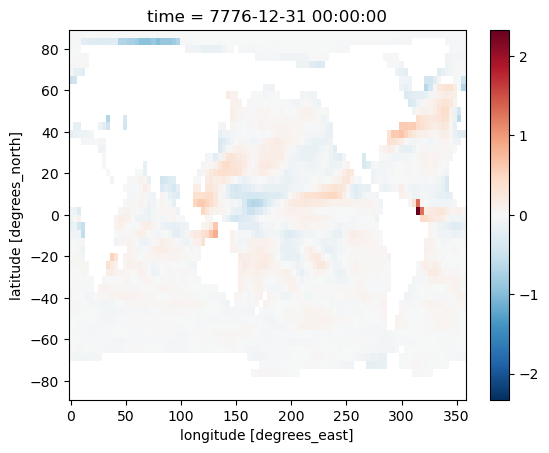

In [49]:
P_E_R_timeseries[100,:,:].plot()

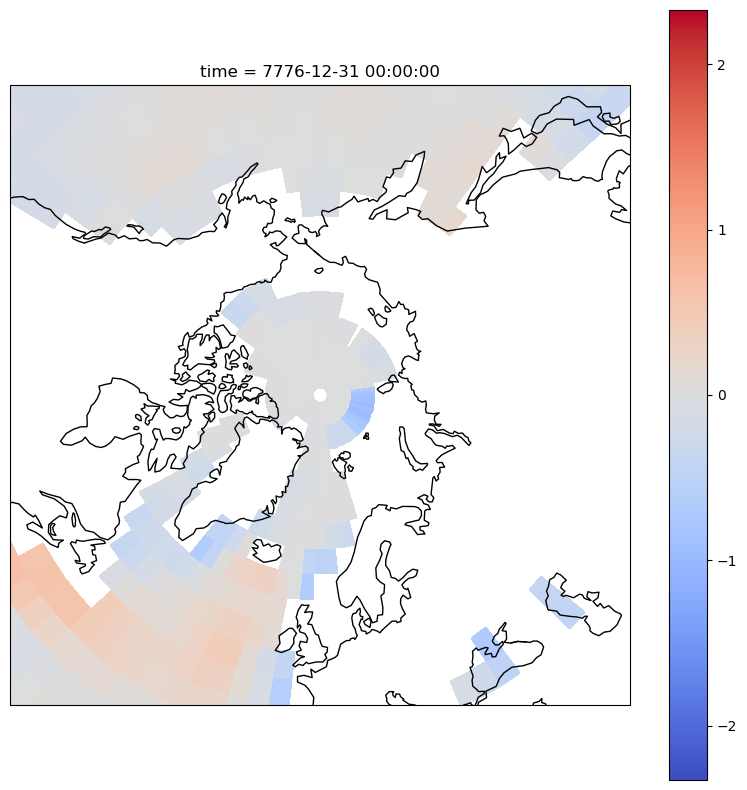

In [50]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

P_E_R_timeseries[100, :, :].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')
# Set the map extent (optional)
# This will show the region from 0°N to 90°N
ax.set_extent([-180, 180, 45, 90], crs=ccrs.PlateCarree())
ax.coastlines()

In [51]:
@interact(time_index=(0, len(PRECT_timeseries.time) - 1))
def plot_timeseries(time_index):
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    P_E_R_timeseries[time_index, :, :].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', levels=np.linspace(-2, 2, 21), extend='both')
    # Set the map extent (optional)
    # This will show the region from 0°N to 90°N
    ax.set_extent([-180, 180, 45, 90], crs=ccrs.PlateCarree())
    ax.coastlines()



interactive(children=(IntSlider(value=165, description='time_index', max=330), Output()), _dom_classes=('widge…

In [52]:
def plot_timeseries(time_index):
    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()})
    iy = 0
    for i, ax in enumerate(axes):
        time_index = 24 + i
        pvar = P_E_R_timeseries[time_index, :, :]
        im = pvar.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm_r', levels=np.linspace(-1, 1, 21), extend='both', add_colorbar=False)
        ax.set_extent([-180, 180, 45, 90], crs=ccrs.PlateCarree())
        ax.coastlines()
        year = 7700 + iy
        ax.set_title(f'P-E+R Year: {year}')
        iy += 1    
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical', pad=0.01, aspect=50)
    plt.tight_layout()


/tmp/ipykernel_288886/2140791304.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


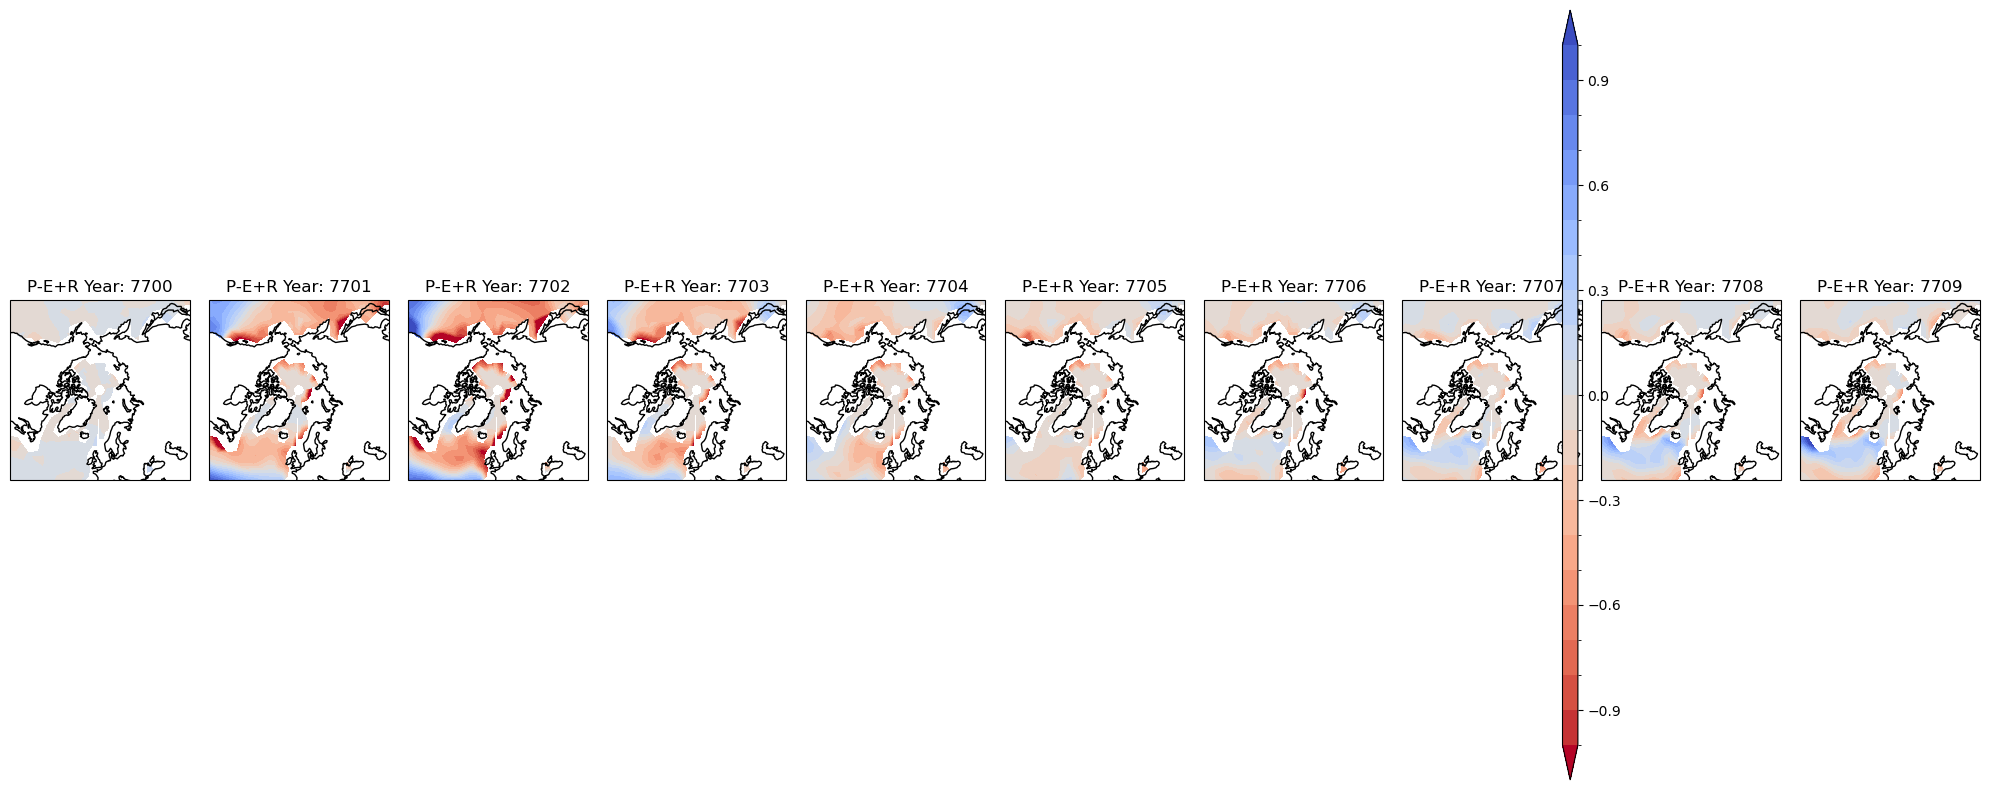

In [53]:
plot_timeseries(0)

In [54]:
def plot_timeseries(time_index):
    # Create figure with slightly more width to accommodate colorbar
    fig = plt.figure(figsize=(22, 10))  # Increased width from 20 to 22

    # Create GridSpec to have better control over subplot layout
    gs = fig.add_gridspec(1, 11, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.05])

    # Create axes for the maps
    axes = []
    for i in range(10):
        ax = fig.add_subplot(gs[0, i], projection=ccrs.NorthPolarStereo())
        axes.append(ax)

    # Create axis for colorbar
    cax = fig.add_subplot(gs[0, -1])

    iy = 0
    for i, ax in enumerate(axes):
        time_index = 24 + i
        pvar = P_E_R_timeseries[time_index, :, :]
        im = pvar.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), 
                               cmap='coolwarm_r', levels=np.linspace(-1, 1, 21), 
                               extend='both', add_colorbar=False)
        ax.set_extent([-180, 180, 45, 90], crs=ccrs.PlateCarree())
        ax.coastlines()
        year = 7700 + iy
        ax.set_title(f'P-E+R Year: {year}')
        iy += 1

    # Add colorbar using the dedicated axis
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')

    plt.tight_layout()

In [55]:
def plot_per_timeseries(time_index):
    # Create figure with slightly more width to accommodate colorbar
    fig = plt.figure(figsize=(22, 3))

    # Create GridSpec to have better control over subplot layout
    gs = fig.add_gridspec(1, 11, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.05])

    # Create axes for the maps
    axes = []
    for i in range(10):
        ax = fig.add_subplot(gs[0, i], projection=ccrs.NorthPolarStereo())
        axes.append(ax)

    # Create axis for colorbar with the same position as the last plot
    cax = fig.add_subplot(gs[0, -1])

    iy = 0
    for i, ax in enumerate(axes):
        time_index = 24 +i
        pvar = P_E_R_timeseries[time_index, :, :]
        im = pvar.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), 
                               cmap='coolwarm_r', levels=np.linspace(-1, 1, 21), 
                               extend='both', add_colorbar=False)
        ax.set_extent([-180, 180, 45, 90], crs=ccrs.PlateCarree())
        ax.coastlines()
        year = 7700 + iy
        ax.set_title(f'P-E+R Year: {year}')
        iy += 1

    # Get the position of the last plot
    last_plot_pos = axes[-1].get_position()

    # Set colorbar position to match the last plot's height
    cax.set_position([cax.get_position().x0,
                     last_plot_pos.y0,
                     cax.get_position().width,
                     last_plot_pos.height])

    # Add colorbar using the adjusted cax
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    # Units on colorbar are in mm/day
    cbar.set_label('Prec - Evap + Runnoff (mm day$^{-1}$)')

    plt.tight_layout()

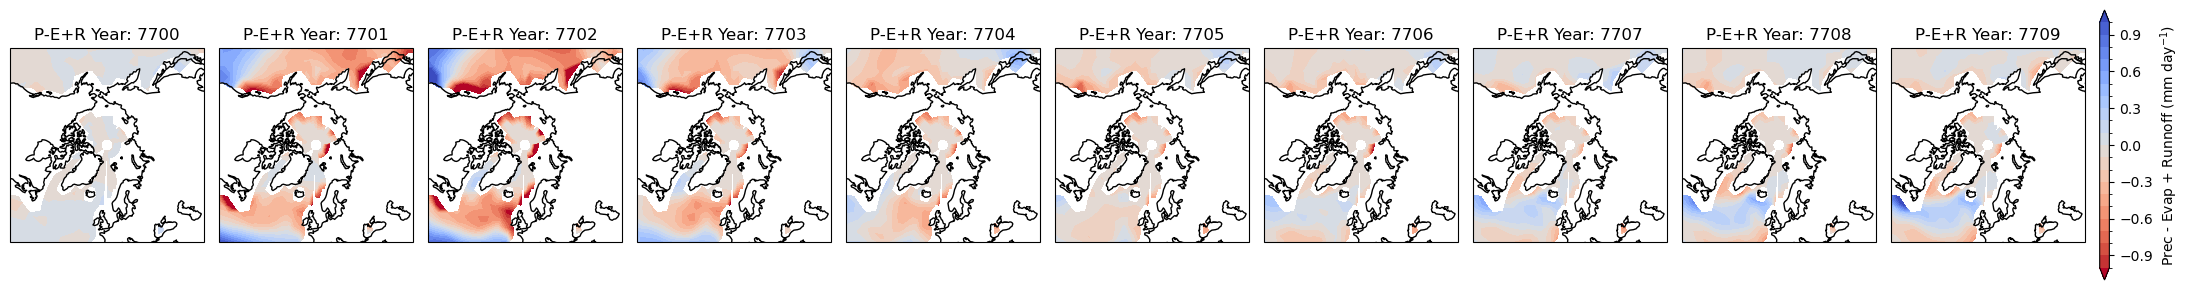

In [56]:
plot_per_timeseries(0)

In [57]:
taux_directory = '/scratch/pproc/eq500tg7701_ens/'
# Load the datasets into xarray
taux_dataset = xr.open_dataset(os.path.join(taux_directory, "cesmi6gat31rblc230iveq-noeq500tg7701_atm_TAUX_ncea.nc"), decode_times=time_coder, decode_timedelta=True).TAUX.resample(time='YE').mean()


In [58]:
taux_dataset

<xarray.DataArray 'TAUX' (time: 331, lat: 48, lon: 96)> Size: 6MB
array([[[ 5.10450591e-05,  5.18134948e-05,  5.99798077e-05, ...,
          4.81087372e-05,  4.97101246e-05,  5.02332114e-05],
        [ 2.14425003e-04,  1.95624903e-04,  2.08451165e-04, ...,
          3.49386333e-04,  3.33110220e-04,  2.49810342e-04],
        [-3.95152565e-05,  4.56098314e-05,  2.21791925e-05, ...,
         -1.87366182e-04, -2.32328413e-04, -1.83355573e-04],
        ...,
        [ 3.67939938e-05,  6.16335747e-05,  1.45364960e-04, ...,
          4.38142815e-05,  1.96355813e-05,  9.14590510e-06],
        [-1.32776288e-04, -1.63569217e-04, -1.99475238e-04, ...,
          1.11605674e-04, -1.54792160e-05, -9.17616926e-05],
        [-3.57147801e-04, -4.04267106e-04, -4.57073300e-04, ...,
         -1.74723944e-04, -2.38730107e-04, -3.07781971e-04]],

       [[ 2.10329075e-04,  2.50062876e-04,  2.93804478e-04, ...,
          1.08186250e-04,  1.51773056e-04,  1.85275640e-04],
        [-6.66774940e-05, -4.81026946e-05,  2.30521735e-07, ...,
          3.40682454e-05,  8.84647015e-05,  2.58643795e-05],
        [-6.15855388e-04, -6.20767009e-04, -3.96133313e-04, ...,
         -2.94935744e-04, -7.15513539e-04, -7.88269739e-04],
...
         -6.82737678e-04,  8.02739523e-05, -2.40611353e-05],
        [ 1.15142774e-03,  9.59379657e-04,  7.72264320e-04, ...,
          1.47467293e-03,  1.37762388e-03,  1.31950423e-03],
        [ 1.28362037e-04, -1.37335155e-05, -2.19390960e-04, ...,
          6.13911310e-04,  4.58224589e-04,  2.73599144e-04]],

       [[ 1.92900677e-03,  2.05150456e-03,  2.22293055e-03, ...,
          1.91230874e-03,  2.06965813e-03,  2.00040266e-03],
        [-3.23335640e-04, -3.75525560e-04, -1.84311997e-04, ...,
         -1.47142634e-03, -7.28897750e-04, -3.95065174e-04],
        [-1.57261826e-03, -1.74162444e-03, -2.04971898e-03, ...,
         -4.11399081e-03, -2.54853070e-03, -1.97193027e-03],
        ...,
        [ 2.74172984e-04,  5.30743971e-04,  5.41055575e-04, ...,
         -9.31491144e-04, -3.21785454e-04, -4.92008403e-05],
        [ 1.08909048e-03,  1.60624273e-03,  2.05437373e-03, ...,
         -6.52819872e-05,  2.50115991e-04,  6.12974167e-04],
        [ 1.33645814e-03,  1.47437770e-03,  1.65203959e-03, ...,
          8.77983868e-04,  9.94058326e-04,  1.17220916e-03]]],
      shape=(331, 48, 96), dtype=float32)
Coordinates:
  * time     (time) object 3kB 7676-12-31 00:00:00 ... 8006-12-31 00:00:00
  * lat      (lat) float64 384B -87.16 -83.48 -79.78 ... 79.78 83.48 87.16
  * lon      (lon) float64 768B 0.0 3.75 7.5 11.25 ... 345.0 348.8 352.5 356.2
Attributes:
    units:         N/m2
    long_name:     Zonal surface stress
    cell_methods:  time: mean

In [59]:
def plot_taux_timeseries(time_index):
    # Create figure with slightly more width to accommodate colorbar
    fig = plt.figure(figsize=(22, 3))

    # Create GridSpec to have better control over subplot layout
    gs = fig.add_gridspec(1, 11, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.05])

    # Create axes for the maps
    axes = []
    for i in range(10):
        ax = fig.add_subplot(gs[0, i], projection=ccrs.NorthPolarStereo())
        axes.append(ax)

    # Create axis for colorbar with the same position as the last plot
    cax = fig.add_subplot(gs[0, -1])

    iy = 0
    for i, ax in enumerate(axes):
        time_index = 24 + i
        pvar = taux_dataset[time_index, :, :]
        im = pvar.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), 
                               cmap=ocm.cm.balance, levels=np.linspace(-1e-1, 1e-1, 21), 
                               extend='both', add_colorbar=False)
        ax.set_extent([-180, 180, 45, 90], crs=ccrs.PlateCarree())
        ax.coastlines()
        year = 7700 + iy
        ax.set_title(f'TAUX Year: {year}')
        iy += 1

    # Get the position of the last plot
    last_plot_pos = axes[-1].get_position()

    # Set colorbar position to match the last plot's height
    cax.set_position([cax.get_position().x0,
                     last_plot_pos.y0,
                     cax.get_position().width,
                     last_plot_pos.height])

    # Add colorbar using the adjusted cax
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    # Units on colorbar are in N/m^2
    cbar.set_label('Zonal Windstress (N m$^{-2}$)')
    plt.tight_layout()

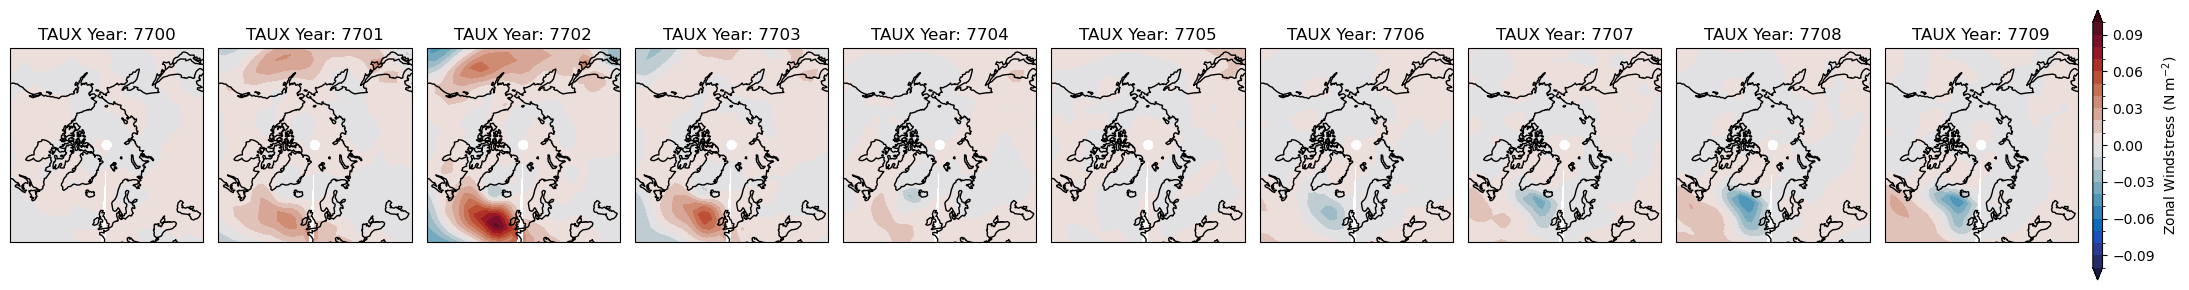

In [60]:
plot_taux_timeseries(0)

In [61]:
ts_directory = '/scratch/pproc/eq500tg7701_ens/'
# Load the datasets into xarray
ts_dataset = xr.open_dataset(os.path.join(ts_directory, "cesmi6gat31rblc230iveq-noeq500tg7701_atm_TS_ncea.nc"), decode_times=time_coder, decode_timedelta=True).TS.resample(time='YE').mean()


In [62]:
def plot_ts_timeseries(time_index):
    # Create figure with slightly more width to accommodate colorbar
    fig = plt.figure(figsize=(22, 3))

    # Create GridSpec to have better control over subplot layout
    gs = fig.add_gridspec(1, 11, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.05])

    # Create axes for the maps
    axes = []
    for i in range(10):
        ax = fig.add_subplot(gs[0, i], projection=ccrs.NorthPolarStereo())
        axes.append(ax)

    # Create axis for colorbar with the same position as the last plot
    cax = fig.add_subplot(gs[0, -1])

    iy = 0
    for i, ax in enumerate(axes):
        time_index = 24 + i
        pvar = ts_dataset[time_index, :, :]
        im = pvar.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), 
                               cmap=ocm.cm.balance, levels=np.linspace(-10, 10, 21), 
                               extend='both', add_colorbar=False)
        ax.set_extent([-180, 180, 45, 90], crs=ccrs.PlateCarree())
        ax.coastlines()
        year = 7700 + iy
        ax.set_title(f'TS Year: {year}')
        iy += 1

    # Get the position of the last plot
    last_plot_pos = axes[-1].get_position()

    # Set colorbar position to match the last plot's height
    cax.set_position([cax.get_position().x0,
                     last_plot_pos.y0,
                     cax.get_position().width,
                     last_plot_pos.height])

    # Add colorbar using the adjusted cax
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    # Units on colorbar are in N/m^2
    cbar.set_label('Surface Air Temperature (K)')
    plt.tight_layout()

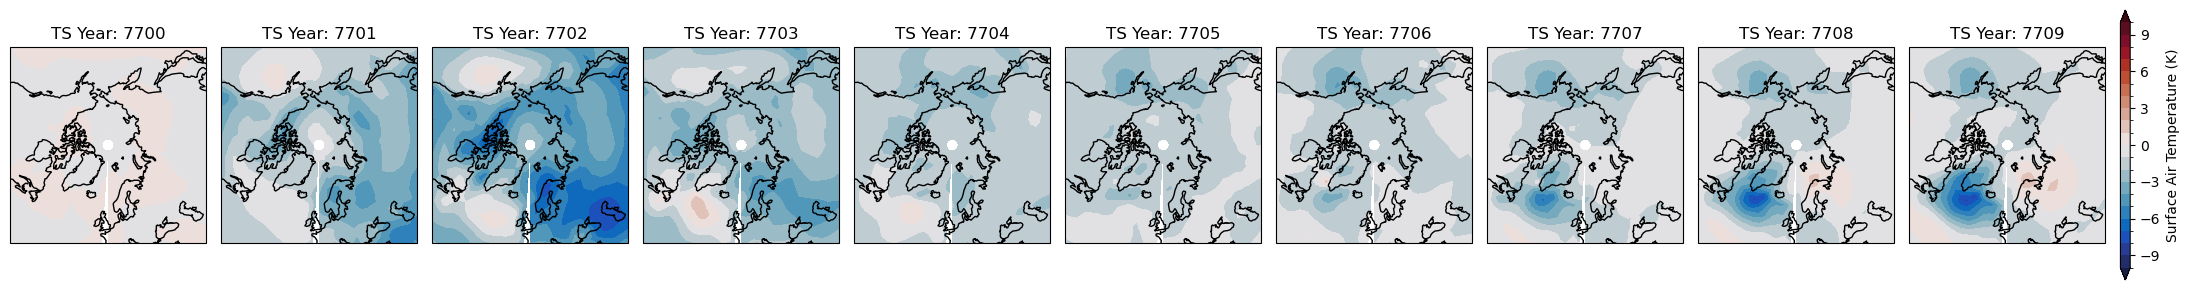

In [63]:
plot_ts_timeseries(0)

In [64]:
psl_directory = '/scratch/pproc/eq500tg7701_ens/'
# Load the datasets into xarray
psl_dataset = xr.open_dataset(os.path.join(psl_directory, "cesmi6gat31rblc230iveq-noeq500tg7701_atm_PSL_ncea.nc"), decode_times=time_coder, decode_timedelta=True).PSL.resample(time='YE').mean()
def plot_psl_timeseries(time_index):
    # Create figure with slightly more width to accommodate colorbar
    fig = plt.figure(figsize=(22, 3))

    # Create GridSpec to have better control over subplot layout
    gs = fig.add_gridspec(1, 11, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.05])

    # Create axes for the maps
    axes = []
    for i in range(10):
        ax = fig.add_subplot(gs[0, i], projection=ccrs.NorthPolarStereo())
        axes.append(ax)

    # Create axis for colorbar with the same position as the last plot
    cax = fig.add_subplot(gs[0, -1])

    iy = 0
    for i, ax in enumerate(axes):
        time_index = 24 + i
        pvar = ts_dataset[time_index, :, :]
        im = pvar.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), 
                               cmap=ocm.cm.curl, levels=np.linspace(-10, 10, 21), 
                               extend='both', add_colorbar=False)
        ax.set_extent([-180, 180, 45, 90], crs=ccrs.PlateCarree())
        ax.coastlines()
        year = 7700 + iy
        ax.set_title(f'PSL Year: {year}')
        iy += 1

    # Get the position of the last plot
    last_plot_pos = axes[-1].get_position()

    # Set colorbar position to match the last plot's height
    cax.set_position([cax.get_position().x0,
                     last_plot_pos.y0,
                     cax.get_position().width,
                     last_plot_pos.height])

    # Add colorbar using the adjusted cax
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    # Units on colorbar are in N/m^2
    cbar.set_label('Mean Sea Level Pressure (Pa)')
    plt.tight_layout()

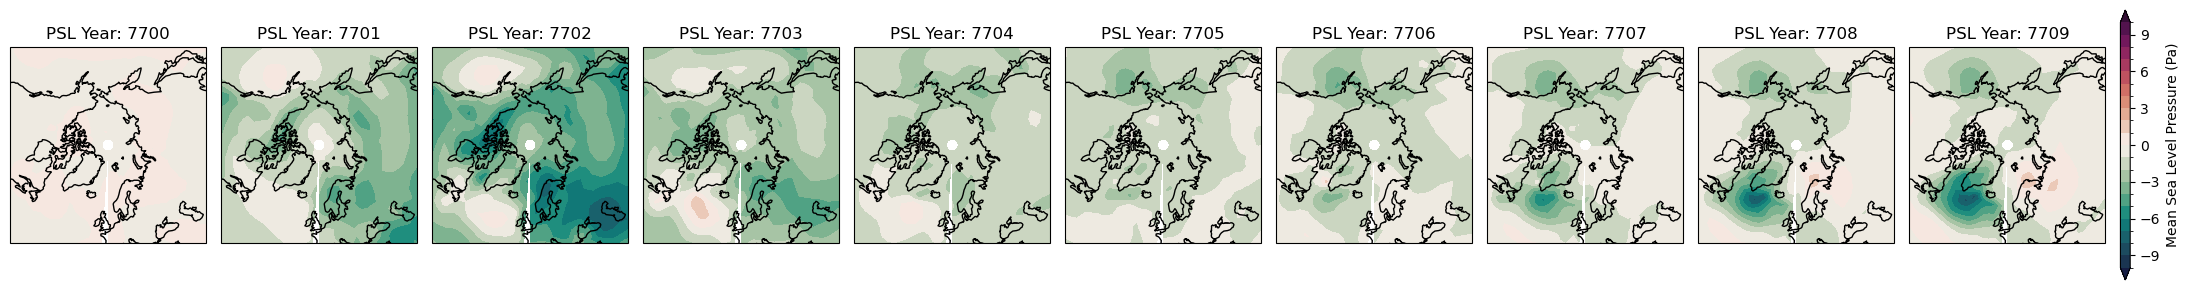

In [65]:
plot_psl_timeseries(0)

In [66]:
# Define helper functions to load and process various atmospheric and oceanic variables
# These functions standardize the loading process for multiple climate fields
# All functions return annual-mean time series of ensemble-mean anomalies (volcanic - control)
def load_atm_average_variable(directory, variable_name):
    # Construct the file path
    file_path = os.path.join(directory, f"cesmi6gat31rblc230iveq-noeq500tg7701_atm_{variable_name}_ncea.nc")
    
    # Load the dataset into xarray
    dataset = xr.open_dataset(file_path, decode_times=time_coder, decode_timedelta=True)
    
    # Extract the variable and perform yearly averaging
    variable_timeseries = dataset[variable_name].resample(time='YE').mean()
    
    return variable_timeseries
def load_ocn_average_variable(directory, variable_name):
    # Construct the file path
    file_path = os.path.join(directory, f"cesmi6gat31rblc230iveq-noeq500tg7701_ocn_{variable_name}_ncea.nc")
    
    # Load the dataset into xarray
    dataset = xr.open_dataset(file_path, decode_times=time_coder, decode_timedelta=True)
    
    # Extract the variable and perform yearly averaging
    variable_timeseries = regridder(dataset[variable_name]).resample(time='YE').mean()
    
    return variable_timeseries
def load_atm_average_volcvariable(directory, variable_name):
    # Construct the file path
    file_path = os.path.join(directory, f"cesmi6gat31rblc230iveq500tg7701_ocn_{variable_name}_ncea.nc")
    
    # Load the dataset into xarray
    dataset = xr.open_dataset(file_path, decode_times=time_coder, decode_timedelta=True)
    
    # Extract the variable and perform yearly averaging
    variable_timeseries = regridder(dataset[variable_name]).resample(time='YE').mean()
    
    return variable_timeseries
def load_ocn_SSS_average(directory, variable_name):
    # Construct the file path
    file_path = os.path.join(directory, f"cesmi6gat31rblc230iveq-noeq500tg7701_ocn_SSS_ncea.nc")
    
    # Load the dataset into xarray
    dataset = xr.open_dataset(file_path, decode_times=time_coder, decode_timedelta=True)
    
    # Extract the variable and perform yearly averaging
    variable_timeseries = regridder(dataset['SALT']).resample(time='YE').mean()
    
    return variable_timeseries

def load_ocn_MOC_average(directory, variable_name):
    # Construct the file path
    file_path = os.path.join(directory, f"cesmi6gat31rblc230iveq-noeq500tg7701_ocn_MOC_ncea.nc")
    
    # Load the dataset into xarray
    dataset = xr.open_dataset(file_path, decode_times=time_coder, decode_timedelta=True)
    
    # Extract the variable and perform yearly averaging
    variable_timeseries = dataset['MOC'].resample(time='YE').mean()
    
    return variable_timeseries

# Usage

# done manually above for calculation and regriding
#prects  = ('PRECT')

#qflxs  = ('QFLX')
#roffs  = ('ROFF_F')

In [67]:
# Load all climate variables needed for Figure 6 analysis
# Variables loaded:
# - TS: Surface air temperature (K)
# - PSL: Mean sea level pressure (Pa)
# - SALT/SSS: Sea surface salinity (g/kg)
# - ICEFRAC: Sea ice fraction (0-1)
# - BSF: Barotropic stream function (Sv)
# - TAUX, TAUY: Zonal and meridional wind stress (N/m²)
# - HMXL: Mixed layer depth (cm)
# - P_E_R: Net freshwater forcing (mm/day, calculated above)
# Time periods for averaging (3 phases of volcanic response):
# Period 1: 7701-7705 (years 0-5 post-eruption, immediate response)
# Period 2: 7706-7715 (years 5-15 post-eruption, transition phase)

# Period 3: 7716-7720 (years 15-20 post-eruption, recovery phase)
# plt_years = [[7701,7705], [7706,7715], [7716,7720]]

base_directory = '/scratch/pproc/eq500tg7701_ens/'
# now I need to create an averaging over 
tsanom  = load_atm_average_variable(base_directory, 'TS')
peranom = P_E_R_timeseries
pslanom  = load_atm_average_variable(base_directory, 'PSL')
# match variable names for P-E+R
sssanom  = load_ocn_SSS_average(base_directory, 'SALT')
hmxlanom  = load_ocn_average_variable(base_directory, 'HMXL')
iceanom  = load_atm_average_variable(base_directory, 'ICEFRAC')
tauyanom = load_atm_average_variable(base_directory, 'TAUY')
bsfanom  = load_ocn_average_variable(base_directory, 'BSF')
tauxanom = load_atm_average_variable(base_directory, 'TAUX')

In [68]:
# Load Atlantic Meridional Overturning Circulation (AMOC) data
# Sum over all MOC components (Eulerian-mean + eddy-induced + submesoscale)

# Select Atlantic basin (transport_reg=1) to focus on AMOC

# Result: AMOC strength as function of depth (moc_z) and latitude (lat_aux_grid)
mocanom  = load_ocn_MOC_average(base_directory, 'MOC').sum(dim='moc_comp').isel(transport_reg=1)

In [69]:
mocanom

<xarray.DataArray 'MOC' (time: 325, moc_z: 61, lat_aux_grid: 105)> Size: 8MB
array([[[-3.24204541e-03, -3.24204541e-03, -3.24204541e-03, ...,
          1.97343310e-04,  6.56600605e-05,  1.73003573e-05],
        [-1.27978530e-02, -1.27978530e-02, -1.27978530e-02, ...,
         -4.30338643e-03, -4.51596268e-03, -4.91895294e-03],
        [-1.62455663e-02, -1.62455663e-02, -1.62455663e-02, ...,
         -2.22288724e-03, -2.32393015e-03, -2.46941438e-03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -3.03818894e-07, -3.03818894e-07, -3.03818894e-07],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          2.58542315e-07,  2.58542315e-07,  2.58542315e-07],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.11201277e-03,  1.11201277e-03,  1.11201277e-03, ...,
         -1.43123209e-04, -5.20096401e-05, -1.85315457e-05],
        [ 1.90767013e-02,  1.90767013e-02,  1.90767013e-02, ...,
          9.29078180e-03,  9.15022846e-03,  9.09731817e-03],
        [ 3.88066322e-02,  3.88066322e-02,  3.88066322e-02, ...,
          1.16502773e-02,  1.17193125e-02,  1.15378210e-02],
...
          1.97381027e-07,  1.97381027e-07,  1.97381027e-07],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.66932097e-07, -1.66932097e-07, -1.66932097e-07],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-4.22286764e-02, -4.22286764e-02, -4.22286764e-02, ...,
          1.43455889e-03,  2.92325858e-04, -1.26820989e-04],
        [-1.68354213e-01, -1.68354213e-01, -1.68354213e-01, ...,
          1.79322548e-02,  1.39369238e-02,  1.66624803e-02],
        [-2.58173645e-01, -2.58173645e-01, -2.58173645e-01, ...,
          3.39883529e-02,  2.85237785e-02,  3.14202905e-02],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.48887611e-05, -1.48887611e-05, -1.48887611e-05],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.23312784e-05,  1.23312784e-05,  1.23312784e-05],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]],
      shape=(325, 61, 105), dtype=float32)
Coordinates:
  * time          (time) object 3kB 7676-12-31 00:00:00 ... 8000-12-31 00:00:00
  * moc_z         (moc_z) float32 244B 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid  (lat_aux_grid) float32 420B -80.26 -78.73 ... 88.38 90.0
Attributes:
    long_name:     Meridional Overturning Circulation
    units:         Sverdrups
    cell_methods:  time: mean

In [70]:
# Calculate period averages for all variables across three temporal phases
# This reduces annual time series to 3 representative snapshots showing evolution
# Each period captures a distinct phase of the volcanic-AMOC response:
# - Period 1 (0-5 yr): Immediate cooling, freshening, and atmospheric circulation changes
# - Period 2 (5-15 yr): Transition phase with cumulative effects on ocean circulation
# - Period 3 (15-20 yr): Recovery phase as system begins to return toward equilibrium
# Creates lists (e.g., ts_ens, psl_ens) with 3 elements, one per period
## I want to take a variable and average over the year segment.sel(time=time_ref.dt.year.isin(year_sel)).mean('time')
## I need a loop to average sections of time over a set variables
vars = [tsanom, pslanom, sssanom, iceanom, bsfanom, tauxanom, tauyanom, hmxlanom, peranom] 
plt_years = [[7701,7705], [7706,7715], [7716,7720]]
def average_over_years(variable, years):
    return variable.sel(time=variable.time.dt.year.isin(range(years[0], years[1]))).mean('time')
## I need a loop to average sections of time over a set variables and 3 sections of year plt_years = [[7701,7705], [7706,7715], [7716,7720]]
## loop over the variables and years segments
ts_ens = []
psl_ens = []
sss_ens = []
ice_ens = []
bsf_ens = []
taux_ens = []
tauy_ens = []
hmxl_ens = []
per_ens = []
moc_ens = []
for years in plt_years:
    ts_ens.append(average_over_years(tsanom, years))
    psl_ens.append(average_over_years(pslanom, years))
    sss_ens.append(average_over_years(sssanom, years))
    ice_ens.append(average_over_years(iceanom, years))
    bsf_ens.append(average_over_years(bsfanom, years))
    taux_ens.append(average_over_years(tauxanom, years))

    tauy_ens.append(average_over_years(tauyanom, years))

    hmxl_ens.append(average_over_years(hmxlanom, years))

    per_ens.append(average_over_years(peranom, years))
    moc_ens.append(average_over_years(mocanom, years))

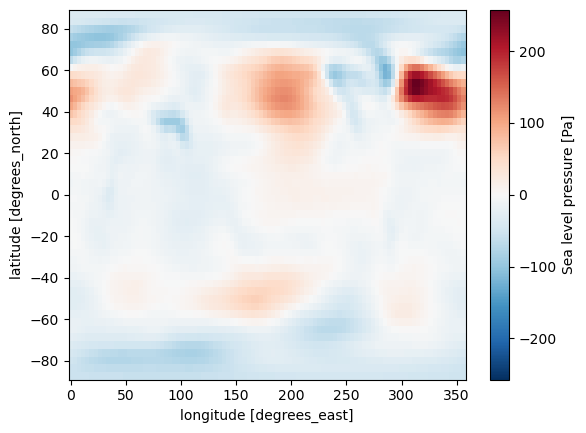

In [71]:
psl_ens[1].plot()

In [72]:
moc_ens[0]

<xarray.DataArray 'MOC' (moc_z: 61, lat_aux_grid: 105)> Size: 26kB
array([[ 5.5087567e-03,  5.5087567e-03,  5.5087567e-03, ...,
         7.7653967e-05,  1.9195475e-05, -2.3486900e-06],
       [ 1.0648091e-01,  1.0648091e-01,  1.0648091e-01, ...,
         2.6971625e-02,  2.5901772e-02,  2.7210653e-02],
       [ 1.2437049e-01,  1.2437049e-01,  1.2437049e-01, ...,
         3.7987139e-02,  3.1099256e-02,  3.3645201e-02],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         2.5319628e-07,  2.5319628e-07,  2.5319628e-07],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.0902311e-07, -2.0902311e-07, -2.0902311e-07],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],
      shape=(61, 105), dtype=float32)
Coordinates:
  * moc_z         (moc_z) float32 244B 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid  (lat_aux_grid) float32 420B -80.26 -78.73 ... 88.38 90.0
Attributes:
    long_name:     Meridional Overturning Circulation
    units:         Sverdrups
    cell_methods:  time: mean

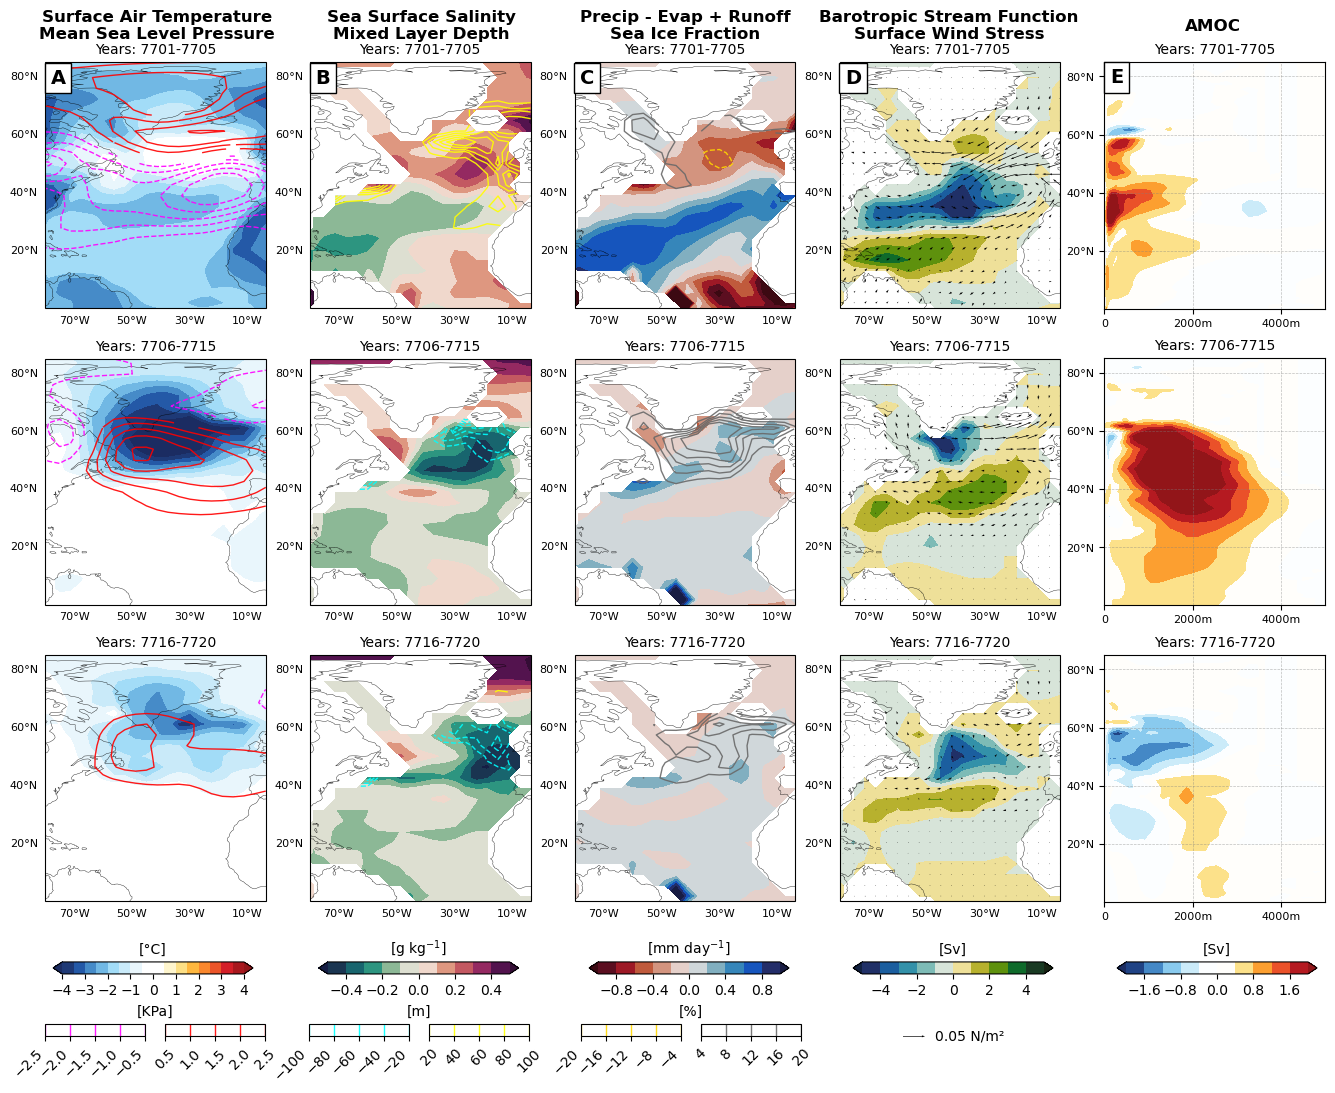

In [73]:
# Generate Figure 6: 3-row × 5-column multi-field analysis showing temporal evolution
# Each row represents one time period (0-5 yr, 5-15 yr, 15-20 yr post-eruption)
# Each column shows a different climate field combination:
# A: TS (filled) + PSL (contours)
# B: SSS (filled) + HMXL (contours)  
# C: P-E+R (filled) + ICEFRAC (contours)
# D: BSF (filled) + wind stress vectors
# E: AMOC depth-latitude section
# Figure reveals spatial patterns and temporal evolution of coupled climate response
moc_z = mocanom.moc_z
moc_lat = mocanom.lat_aux_grid
nrow      = 3
ncol      = 5
lon_cnt   = 180
alpha     = 0.05
iw        = 1  # quiver subsampling (every 1st grid point)
# contour alpha
calpha    = 0.9

# Define contour levels for each variable
bd_ts     = np.linspace(-4, 4, 17)        # Surface air temp (°C)
bd_psl    = np.linspace(-2.5, 2.5, 11)    # Sea level pressure (KPa)
bd_sss    = np.linspace(-0.5, 0.5, 11)    # Sea surface salinity (g/kg)
bd_hmxl   = np.linspace(-100, 100, 11)    # Mixed layer depth (m)
bd_per    = np.linspace(-1, 1, 11)        # P-E+R (mm/day)
bd_ice    = np.linspace(-20, 20, 11)      # Sea ice fraction (%)
bd_bsf    = np.linspace(-5, 5, 11)        # Barotropic streamfunction (Sv)
bd_moc    = np.linspace(-2, 2, 11)        # AMOC (Sv)
data_proj = ccrs.PlateCarree(central_longitude=180)
fig       = plt.figure(figsize=(16, 12))
gs        = gridspec.GridSpec(nrow, ncol, figure=fig)
cmap      = cmaps.BlueWhiteOrangeRed
extent    = [100, lon[-1]-lon_cnt, 0, 85]  # Map extent: 100°E-180°W, 0-85°N (Northern Hemisphere focus)
tscmap    = cmaps.BlueWhiteOrangeRed      # Diverging colormap for temperature
ssscmap   = ocm.cm.curl                    # Oceanographic colormap for salinity
percmap   = ocm.cm.balance_r               # Balanced colormap for freshwater
bsfcmap   = ocm.cm.delta                   # Colormap for circulation

# label pos
lx = 0.025
ly = 0.915
firstlabel=True

for p in range(nrow):
    iyr, fyr = plt_years[p][0], plt_years[p][1]
    #print(p)
    ## 1. (TS + PSL)
    ax1 = fig.add_subplot(gs[p, 0], projection=data_proj)
    ts_enmean = ts_ens[p]
    psl_enmean = psl_ens[p]/100.
    CTS = ax1.contourf(lon-lon_cnt, lat, ts_enmean,  bd_ts, transform=data_proj, extend='both', cmap=tscmap)
    CPSL_pos = ax1.contour(lon-lon_cnt, lat, psl_enmean.where(psl_enmean > 0), bd_psl[bd_psl > 0], transform=data_proj, colors='red', linewidths=1.0, alpha=calpha)
    CPSL_neg = ax1.contour(lon-lon_cnt, lat, psl_enmean.where(psl_enmean < 0), bd_psl[bd_psl < 0], transform=data_proj, colors='magenta', linewidths=1.0, alpha=calpha)
    ax1.coastlines(linewidth=0.3, color='black', alpha=0.9)
    ax1.set_extent(extent, crs=data_proj)
    gl = ax1.gridlines(draw_labels=True, linewidth=0)
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    gl.top_labels = False
    gl.right_labels = False
    ax1.set_title(f'Years: {iyr}-{fyr}', fontsize=10)        
    ## 2. (SSS + HMXL)
    ax2 = fig.add_subplot(gs[p, 1], projection=data_proj)
    sss_enmean = sss_ens[p]
    hmxl_enmean = hmxl_ens[p]/100.
    CSSS = ax2.contourf(lon-lon_cnt, lat, sss_enmean,  bd_sss, transform=data_proj, extend='both', cmap=ssscmap)
    CHMXL_pos = ax2.contour(lon-lon_cnt, lat, hmxl_enmean.where(hmxl_enmean > 0), bd_hmxl[bd_hmxl > 0], transform=data_proj, colors='yellow', linewidths=1.0, alpha=calpha)
    CHMXL_neg = ax2.contour(lon-lon_cnt, lat, hmxl_enmean.where(hmxl_enmean < 0), bd_hmxl[bd_hmxl < 0], transform=data_proj, colors='cyan', linewidths=1.0, alpha=calpha)
    ax2.coastlines(linewidth=0.3, color='black', alpha=0.9)
    ax2.set_extent(extent, crs=data_proj)
    gl = ax2.gridlines(draw_labels=True, linewidth=0)
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    gl.top_labels = False
    gl.right_labels = False
    ax2.set_title(f'Years: {iyr}-{fyr}', fontsize=10)        
    ## 3. (PER + ICEFRAC)
    ax3 = fig.add_subplot(gs[p, 2], projection=data_proj)
    per_enmean = per_ens[p]
    ice_con = ice_ens[p]*100.0
    CPER = ax3.contourf(lon-lon_cnt, lat, per_enmean,  bd_per, transform=data_proj, extend='both', cmap=percmap)
    CICE_pos = ax3.contour(lon-lon_cnt, lat, ice_con.where(ice_con > 0), bd_ice[bd_ice > 0], transform=data_proj, colors='dimgray', linewidths=1.0, alpha=calpha)
    CICE_neg = ax3.contour(lon-lon_cnt, lat, ice_con.where(ice_con < 0), bd_ice[bd_ice < 0], transform=data_proj, colors='gold', linewidths=1.0, alpha=calpha)
    #CICE_pos = ax3.contour(lon-lon_cnt, lat, ice_con, levels = ice_levels, transform=data_proj, colors='white', linewidths=1.0, alpha=calpha)
    #CICE_pos = ax3.contour(lon-lon_cnt, lat, [ice_con.where(ice_con>0), ice_con.where(ice_con<0)][0], transform=data_proj, colors='white', linewidths=1.0, alpha=calpha)
    ax3.coastlines(linewidth=0.3, color='black', alpha=0.9)
    ax3.set_extent(extent, crs=data_proj)
    gl = ax3.gridlines(draw_labels=True, linewidth=0)
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    gl.top_labels = False
    gl.right_labels = False
    ax3.set_title(f'Years: {iyr}-{fyr}', fontsize=10)        
    ## 4. (BSF + TAU)
    ax4 = fig.add_subplot(gs[p, 3], projection=data_proj)
    bsf_enmean = bsf_ens[p]
    taux     = taux_ens[p]
    tauy     = tauy_ens[p]

    CBSF = ax4.contourf(lon-lon_cnt, lat, bsf_enmean,  bd_bsf, transform=data_proj, extend='both', cmap=bsfcmap)
    CQ = ax4.quiver  (lon[::iw]-lon_cnt, lat[::iw], -taux[::iw,::iw], -tauy[::iw,::iw], \
                        transform=data_proj, color='k', scale=0.5, width=0.003)
    ax4.coastlines(linewidth=0.3, color='black', alpha=0.9)
    ax4.set_extent(extent, crs=data_proj)
    gl = ax4.gridlines(draw_labels=True, linewidth=0)
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    gl.top_labels = False
    gl.right_labels = False
    ax4.set_title(f'Years: {iyr}-{fyr}', fontsize=10)        
    ## 5. (MOC)
    ax5 = fig.add_subplot(gs[p, 4])
    moc_enmean = moc_ens[p]
    C5 = ax5.contourf(moc_z/100, moc_lat, moc_enmean.T, bd_moc, extend='both', cmap=cmap)
    ax5.set_title(f'Years: {iyr}-{fyr}', fontsize=10)
    ax5.set_ylim(extent[2], extent[3])
    ax5.set_yticks(np.arange(20, 90, 20))
    ax5.set_yticklabels(['20°N','40°N','60°N','80°N'], fontsize=8)
    ax5.set_xlim(0, 5000)
    ax5.set_xticks([0, 2000, 4000])
    ax5.set_xticklabels(['0', '2000m','4000m'], fontsize=8)
    ax5.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    if firstlabel:
        # Add text with bounding boxes
        ax1.text(lx, ly, 'A', transform=ax1.transAxes, size=14, weight='bold',
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='Square'))
        ax2.text(lx, ly, 'B', transform=ax2.transAxes, size=14, weight='bold',
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='Square'))
        ax3.text(lx, ly, 'C', transform=ax3.transAxes, size=14, weight='bold',
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='Square'))
        ax4.text(lx, ly, 'D', transform=ax4.transAxes, size=14, weight='bold',
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='Square'))
        ax5.text(lx, ly, 'E', transform=ax5.transAxes, size=14, weight='bold',
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='Square'))
        firstlabel=False


plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2, wspace=0.2, hspace=0.2)

titles = ['Surface Air Temperature\nMean Sea Level Pressure', 'Sea Surface Salinity\nMixed Layer Depth',
           'Precip - Evap + Runoff\nSea Ice Fraction', 'Barotropic Stream Function\nSurface Wind Stress', 'AMOC']
for col, title in enumerate(titles):
    fig.text(0.17 + col * 0.165, 0.93, title, ha='center', va='center', fontsize=12, fontweight='bold')
bar1y = 0.14
bar2y = 0.088
cbar1 = fig.colorbar(CTS, cax=fig.add_axes([0.105, bar1y, 0.125, 0.01]), orientation='horizontal') # [left, bottom, width, height]
cbar1a = fig.colorbar(CPSL_neg, cax=fig.add_axes([0.10, bar2y, 0.0625, 0.01]), orientation='horizontal') # [left, bottom, width, height]
cbar1b = fig.colorbar(CPSL_pos, cax=fig.add_axes([0.175, bar2y, 0.0625, 0.01]), orientation='horizontal') # [left, bottom, width, height]

cbar2 = fig.colorbar(CSSS, cax=fig.add_axes([0.271, bar1y, 0.125, 0.01]), orientation='horizontal') # [left, bottom, width, height]
cbar2a = fig.colorbar(CHMXL_neg, cax=fig.add_axes([0.265, bar2y, 0.0625, 0.01]), orientation='horizontal') # [left, bottom, width, height]
cbar2b = fig.colorbar(CHMXL_pos, cax=fig.add_axes([0.34, bar2y, 0.0625, 0.01]), orientation='horizontal') # [left, bottom, width, height]

cbar3 = fig.colorbar(CPER, cax=fig.add_axes([0.44, bar1y, 0.125, 0.01]), orientation='horizontal') # [left, bottom, width, height]
cbar3a = fig.colorbar(CICE_neg, cax=fig.add_axes([0.435, bar2y, 0.0625, 0.01]), orientation='horizontal') # [left, bottom, width, height]
cbar3b = fig.colorbar(CICE_pos, cax=fig.add_axes([0.51, bar2y, 0.0625, 0.01]), orientation='horizontal') # [left, bottom, width, height]

cbar4 = fig.colorbar(CBSF, cax=fig.add_axes([0.605, bar1y, 0.125, 0.01]), orientation='horizontal') # [left, bottom, width, height]
ax4.quiverkey(CQ, 0.65, bar2y, 0.05, '0.05 N/m²', labelpos='E', coordinates='figure', fontproperties={'size': 10})

cbar5 = fig.colorbar(C5, cax=fig.add_axes([0.77, bar1y, 0.125, 0.01]), orientation='horizontal') # [left, bottom, width, height]
cfbars = [cbar1, cbar2, cbar3, cbar4, cbar5]
cclbars = [cbar1a, cbar2a, cbar3a]
ccrbars = [cbar1b, cbar2b, cbar3b]
cfunits = ['[°C]', '[g kg$^{-1}$]', '[mm day$^{-1}$]', '[Sv]', '[Sv]']
ccunits = ['[KPa]', '[m]', '[%]']
for x in range(ncol):
    cfbars[x].ax.tick_params(labelsize=10)
    cfbars[x].ax.set_title(cfunits[x], fontsize=10)
    #plt.setp(cfbars[x].ax.get_xticklabels(), rotation=45, ha='right')
for x in range(3):
    cclbars[x].ax.tick_params(labelsize=10)
    cclbars[x].ax.set_title(ccunits[x], fontsize=10, position=(1.1, 1.1))
    plt.setp(cclbars[x].ax.get_xticklabels(), rotation=45, ha='right')
    ccrbars[x].ax.tick_params(labelsize=10)
    #ccrbars[x].ax.set_title(ccunits[x], fontsize=10)

    plt.setp(ccrbars[x].ax.get_xticklabels(), rotation=45,  position=(0.1, 0.02))
